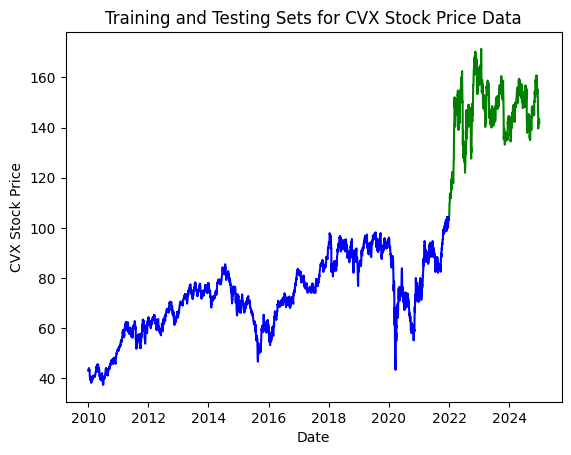

In [4]:
# STAT 574 HW4 Problem 1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statistics import mean
import tensorflow
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from sklearn.metrics import mean_squared_error

# Historical Stock Extraction from Yahoo Finance

# data_download = yf.download('CVX', start='2010-01-01', end='2024-01-01')
# data_download = data_download.drop(columns=["High", "Low", "Open", "Volume"], axis=1)
# print(data_download.head())

# data_download.to_csv('CVX_historical_data.csv')

chevron_data = pd.read_csv("C:/Users/coryg/OneDrive/Desktop/STAT_574_Data_Mining/CVX_historical_data.csv",
                           index_col="Date", parse_dates=["Date"])

# Plotting daily Chevron stock closing prices

train = chevron_data[chevron_data.index < pd.to_datetime("2022-01-02", format='%Y-%m-%d')]
test = chevron_data[chevron_data.index >= pd.to_datetime("2022-01-02", format='%Y-%m-%d')]

plt.plot(train, color = "blue")
plt.plot(test, color = "green")
plt.ylabel('CVX Stock Price')
plt.xlabel('Date')
plt.title("Training and Testing Sets for CVX Stock Price Data")
plt.show()

In [5]:
# Rescaling Chevron data 

chevron_data["Close_sc"] = (chevron_data["Close"]-min(chevron_data["Close"]))/(max(chevron_data["Close"].values)-min(chevron_data["Close"]))

train_set = chevron_data[chevron_data.index < pd.to_datetime("2022-01-02", format='%Y-%m-%d')]
test_set = chevron_data[chevron_data.index >= pd.to_datetime("2022-01-02", format='%Y-%m-%d')]
train_set = train_set.loc[:, "Close_sc"].values
test_set = test_set.loc[:, "Close_sc"].values

nsteps=60

def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

train_x, train_y=split_sequence(train_set, nsteps)

Epoch 1/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0045
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1114e-04
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.0604e-04
Epoch 4/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.1896e-04
Epoch 5/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.1180e-04
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy within 10%: 0.2709
Accuracy within 15%: 0.8194
Accuracy within 20%: 0.9987


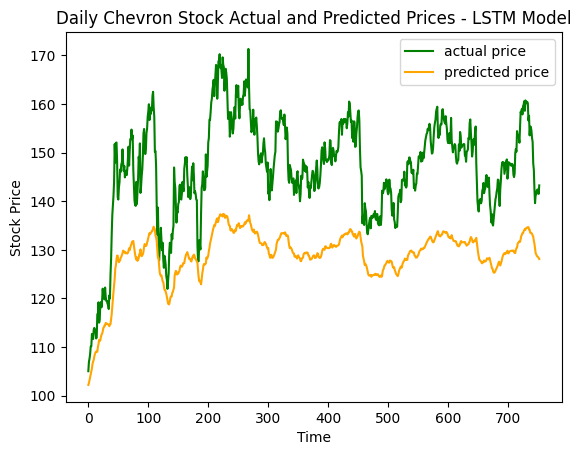

In [7]:
# Fitting LSTM model 

features = 1
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], features)

model_lstm = Sequential()
model_lstm.add(LSTM(units=6, activation="tanh", input_shape=(nsteps, features)))
model_lstm.add(Dense(units=1))

model_lstm.compile(loss="mse")
model_lstm.fit(train_x, train_y, epochs=5, batch_size=32)

# Creating testing set by adding nsteps observations from training set to testing set
inputs=chevron_data.loc[:,"Close_sc"][len(chevron_data)-len(test_set)-nsteps:].values
inputs=inputs.reshape(-1, 1)

# Splitting into samples
test_x, test_y=split_sequence(inputs, nsteps)

# Reshaping
test_x=test_x.reshape(test_x.shape[0], test_x.shape[1], features)

# Predicting for testing data
pred_y=model_lstm.predict(test_x)

# Inverse transforming the values
pred_y=pred_y*(max(chevron_data["Close"].values)-min(chevron_data["Close"]))+min(chevron_data["Close"])
test_y=test_y*(max(chevron_data["Close"].values)-min(chevron_data["Close"]))+min(chevron_data["Close"])

# Computing prediction accuracy
ind10=[]
ind15=[]
ind20=[]     

for sub1, sub2 in zip(pred_y, test_y):
    ind10.append(1) if abs(sub1-sub2)<0.10*sub2 else ind10.append(0)
    ind15.append(1) if abs(sub1-sub2)<0.15*sub2 else ind15.append(0)
    ind20.append(1) if abs(sub1-sub2)<0.20*sub2 else ind20.append(0)
   
print('Accuracy within 10%:', round(mean(ind10),4))
print('Accuracy within 15%:', round(mean(ind15),4))
print('Accuracy within 20%:', round(mean(ind20),4))
    
#plotting actual and predicted values for testing data
plt.plot(test_y, color="green", label="actual price")
plt.plot(pred_y, color="orange", label="predicted price")
plt.title("Daily Chevron Stock Actual and Predicted Prices - LSTM Model")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

Epoch 1/5


c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0524
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0041
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.3160e-04
Epoch 4/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.4043e-04
Epoch 5/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.4531e-04
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
accuracy within 10%: 0.9973
accuracy within 15%: 1
accuracy within 20%: 1


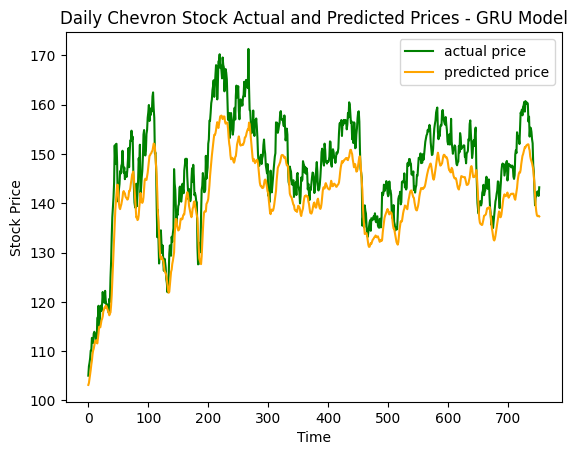

In [8]:
# Fitting GRU Architecture Model

model_gru = Sequential()
model_gru.add(GRU(units=6, activation="tanh", input_shape=(nsteps, features)))
model_gru.add(Dense(units=1))

# Compiling the model
model_gru.compile(loss="mse")
model_gru.fit(train_x, train_y, epochs=5, batch_size=32)

# Predicting for testing data
pred_y=model_gru.predict(test_x)

# Inverse transforming the values
pred_y=pred_y*(max(chevron_data["Close"].values)-min(chevron_data["Close"]))+min(chevron_data["Close"])

# Computing prediction accuracy
ind10=[]
ind15=[]
ind20=[]     

for sub1, sub2 in zip(pred_y, test_y):
    ind10.append(1) if abs(sub1-sub2)<0.10*sub2 else ind10.append(0)
    ind15.append(1) if abs(sub1-sub2)<0.15*sub2 else ind15.append(0)
    ind20.append(1) if abs(sub1-sub2)<0.20*sub2 else ind20.append(0)
   
print('accuracy within 10%:', round(mean(ind10),4))
print('accuracy within 15%:', round(mean(ind15),4))
print('accuracy within 20%:', round(mean(ind20),4))
    
# Plotting actual and predicted values for testing data
plt.plot(test_y, color="green", label="actual price")
plt.plot(pred_y, color="orange", label="predicted price")
plt.title("Daily Chevron Stock Actual and Predicted Prices - GRU Model")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()